# Getting a better sense of `arXiv`

In this notebook we will do some exploration of the information we gathered from `arXiv`. In particular we will do the following:

1. Get a sense of how the submissions are distributed over time.
1. Try to visualize some of the most common words using word clouds. Since the raw text has a lot symbolic entities, I'll use the `detex` copy of the abstracts to generate the word clouds.


We use the following libraries in this notebook:
1. `sqlalchemy` - The library I used to interact with the PostgreSQL database where our information is stored. 
1. `json` - I stored the login credentials for the PostgreSQL database in a `JSON` file, so I used this library to load that information. 
1. `matplotlib` - For plotting. 
1. `pandas` - A library for manipulating data in a tabular format. 
1. `wordcloud` - A library for creating word clouds.
1. `sklearn` - We used the `CountVectorizer` to from this library to build our wordclouds.
1. `itertools` - A module with a number of iterator construcors, we used `chain` to simplify the plotting of multiple word clouds. 


In [1]:
from sqlalchemy import create_engine, Column, String, Integer, DATE, BOOLEAN
from sqlalchemy.orm import sessionmaker

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import func

import json

## Setup our `sqlalchemy`

Load the server credentials so we can actually look at our data. We'll use a `pandas` DataFrame object to hold the infomation locally and do some exploration.

In [2]:
with open('../../postgres.json') as pg_info:
    pg_json = json.load(pg_info)
    pg_username = pg_json['pg_username']
    pg_password = pg_json['pg_password']
    pg_ip = pg_json['pg_ip']

In [3]:
Base = declarative_base()

class articles_detex(Base):
    __tablename__ = 'arxiv_detex'
    
    id = Column(String, primary_key=True)
    created = Column(DATE)
    setspec = Column(String)
    
    title = Column(String)
    title_converted = Column(BOOLEAN)
    
    abstract = Column(String)
    abstract_converted = Column(BOOLEAN)

class articles_pandoc(Base):
    __tablename__ = 'arxiv_pandoc'
    
    id = Column(String, primary_key=True)
    created = Column(DATE)
    setspec = Column(String)
    
    title = Column(String)
    title_converted = Column(BOOLEAN)
    
    abstract = Column(String)
    abstract_converted = Column(BOOLEAN)
    


In [4]:
engine = create_engine(f'postgres://{pg_username}:{pg_password}@{pg_ip}:5432')
Session = sessionmaker(bind=engine)


## Conversion Failures

We went through all the trouble of trying to remove the $\LaTeX$, and at least recorded when our methods failed. Let's go check what happened with that, i.e. how often did `detex` and `pandoc` fail?

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
def conversion_rates(article_class, Session, column='title'):
    
    if column == 'title':
        article_column = article_class.title_converted
    elif column == 'abstract':
        article_column = article_class.abstract_converted
    else:
        print('column must be either "title" or "abstract"')
        return

    session = Session()
    
    query = session.query(article_column, func.count(article_column))
    query = query.group_by(article_column)
    
    df = pd.read_sql(query.statement, query.session.bind).set_index(column + '_converted')
    session.close()
    
    return df

In [7]:
df_detex_title = conversion_rates(articles_detex, Session, column='title')
df_detex_title

,count_1
title_converted,
True,1407628


In [8]:
df_detex_abstract = conversion_rates(articles_detex, Session, column='abstract')
df_detex_abstract

,count_1
abstract_converted,
True,1407628


The tables above show us that `detex` didn't issue an error and returned a value when we tried to process the titles and abstracts. Of course this doesn't mean all is well, let's check the `pandoc` results.

In [9]:
df_pandoc_title = conversion_rates(articles_pandoc, Session, column='title')
df_pandoc_title

,count_1
title_converted,
False,14153
True,1393475


In [10]:
num_articles = df_pandoc_title.count_1.sum()

In [11]:
print(f'pandoc fail rate for TITLES: {100*df_pandoc_title.count_1[False]/num_articles:.2f}%')
print(f'pandoc success rate for TITLES: {100*df_pandoc_title.count_1[True]/num_articles:.2f}%')

pandoc fail rate for TITLES: 1.01%
pandoc success rate for TITLES: 98.99%


In [12]:
df_pandoc_abstract = conversion_rates(articles_pandoc, Session, column='abstract')
df_pandoc_abstract

,count_1
abstract_converted,
False,93656
True,1313972


In [13]:
print(f'pandoc fail rate for ABSTRACTS: {100*df_pandoc_abstract.count_1[False]/num_articles:.2f}%')
print(f'pandoc success rate for ABSTRACTS: {100*df_pandoc_abstract.count_1[True]/num_articles:.2f}%')

pandoc fail rate for ABSTRACTS: 6.65%
pandoc success rate for ABSTRACTS: 93.35%


We'll use the `detex` version of the abstracts that `pandoc` on which performed successfully to build some word clouds. 

## Submissions over time

How has the submission rate to __arXiv__ changed over time? We'll use the `pandas` built in plotting functions to visualize this.

In [14]:
session = Session()

query = (session.query(articles_pandoc.created, 
                      func.count(articles_pandoc.created),
                      )
                 .group_by(articles_pandoc.created) 
        )
submissions_by_date = pd.read_sql(query.statement, query.session.bind)

session.close()

Text(0.5,1,'Submissions by Date')

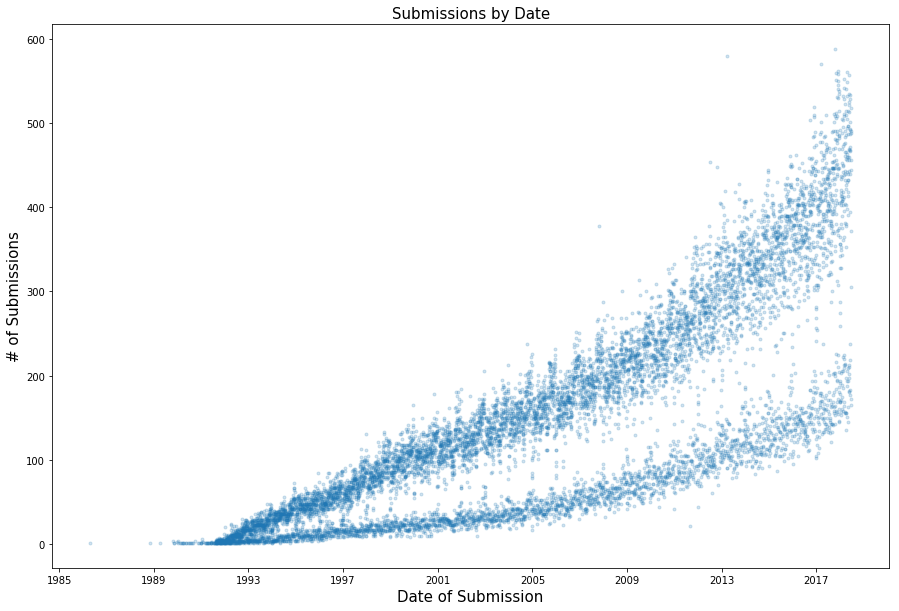

In [15]:
plot_params = {
    'kind':'line',
    'legend':False,
    'x':'created',
    'y':'count_1',
    'style':'.',
    'alpha':.2,
    'figsize':(15,10)
}

ax = submissions_by_date.plot(**plot_params)

ax.set_ylabel('# of Submissions', fontsize=15)
ax.set_xlabel('Date of Submission', fontsize=15)
ax.set_title('Submissions by Date', fontsize=15)

This graph is a bit misleading in that it looks like no one was really using `arXiv` in the first few years, say from 1985 to 1990. This is correct, becasue `arXiv` was founded in 1991! There's a small number of articles that, for whatever reason, have an older `created` date associated to them. 

There seems to be two distinct trends in the plot above. The graph below demonstrates that this division correspond to __weekend__ vs. __weekday__ submissions.

In [18]:
weekend_dict = {
    False:'Weekend',
    True:'Weekday'
}

submissions_by_date['weekday'] = submissions_by_date['created'].map(lambda x: weekend_dict[x.weekday() < 5])

sub_weekday = submissions_by_date.groupby(['weekday'])

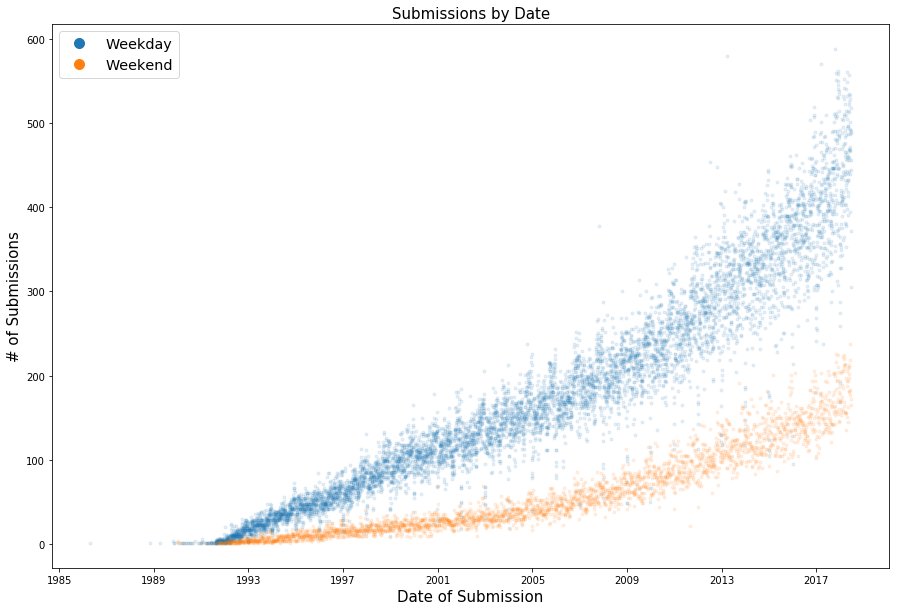

In [21]:
plot_params = {
    'kind':'line',
    'legend':False,
    'x':'created',
    'y':'count_1',
    'style':'.',
    'alpha':.1,
    
}
fig, ax = plt.subplots(figsize=(15,10))
for label, df in sub_weekday:
    df.plot(**plot_params, ax=ax, label=label)


leg = ax.legend(fontsize='x-large')   
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_markersize(20)
    
        
ax.set_ylabel('# of Submissions', fontsize=15)
ax.set_xlabel('Date of Submission', fontsize=15)
ax.set_title('Submissions by Date', fontsize=15)

plt.savefig('./submissions.png')

## Wordclouds

The `setspec` attribute is a bit odd. It is a broad categorical label for articles, there's a list of all of these categories below, together with the total number of papers with that label. You can see that there is much more granularity in the labels associate with physics, whereas all mathematics, computer science etc. articles have no subcategories (at least not in the `setspec` data). 

In [18]:
session = Session()
query = session.query(articles_detex.setspec, func.count(articles_detex.id)).group_by(articles_detex.setspec)
category_count = pd.read_sql(query.statement, query.session.bind)
session.close()

In [19]:
category_count.sort_values(by='count_1', ascending=False)

,setspec,count_1
3,math,332149
5,physics:astro-ph,237810
6,physics:cond-mat,236188
0,cs,171952
10,physics:hep-ph,90017
15,physics:physics,74998
11,physics:hep-th,51589
16,physics:quant-ph,46140
7,physics:gr-qc,42333
8,physics:hep-ex,33535


## Wordclouds
We have a lot of text data, and we have some categorical labels provided in the data itself. Below you can find word clouds build from the abstracts of articles on __arXiv__, grouped by their `setspec` label. You can find all of the word clouds in the [word cloud directory](../../word_clouds) if you'd like to examine any of them more closely. I've displayed the word clouds for math, computer science and high energy physics at the bottom of this notebook.

In [20]:
setspecs_sort = [
    'cs', 'math', 'stat', 'eess', 'econ',
    'nlin', 'q-fin', 'q-bio', 'physics:astro-ph','physics:gr-qc',
    'physics:nlin', 'physics:cond-mat', 'physics:physics', 'physics:nucl-ex', 'physics:nucl-th',
    'physics:hep-ex', 'physics:hep-lat', 'physics:hep-ph', 'physics:hep-th', 'physics:quant-ph',
]

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from itertools import chain

In [22]:
def build_subject_corpus(category, session):
    corpus = []
    query = (session.query(articles_detex.id, articles_pandoc.id, articles_detex.abstract)
             .filter( articles_detex.id == articles_pandoc.id)
             .filter(articles_detex.setspec == category)
             .yield_per(1000)
            )
    
    for abstract_return in query:
        corpus.append(abstract_return.abstract)

    return corpus

In [23]:
def setspec_word_cloud(setspec, corpus, ax):
    wc = WordCloud(background_color="white", stopwords=None, width=2000, height=1000)
    wc = wc.generate(' '.join(corpus))
    
    wc.to_file(f"../../word_clouds/{setspec}_cloud.png")
    wc_colors = wc.to_array()

    ax.set_title(f"{setspec}")
    ax.imshow(wc_colors, interpolation="bilinear")
    ax.axis("off")

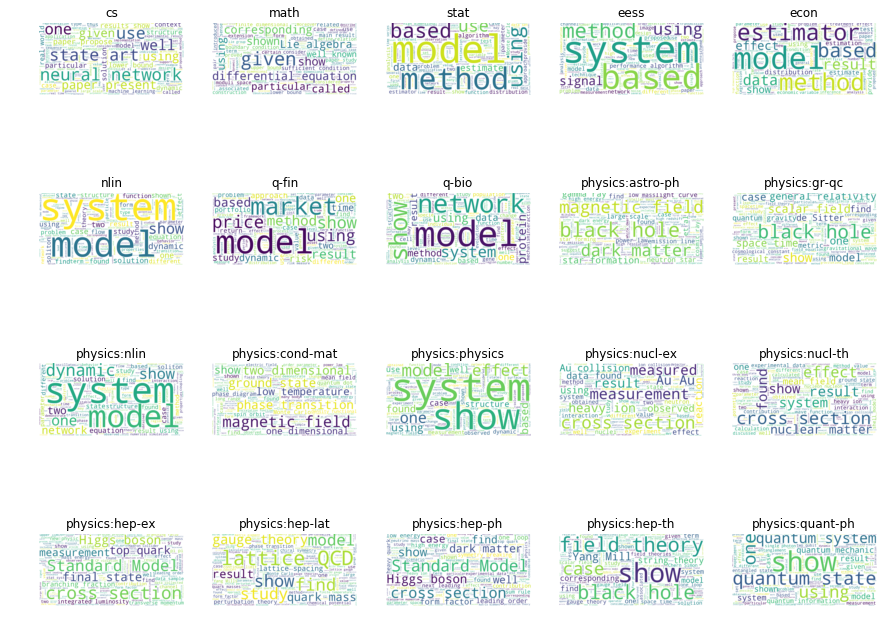

In [24]:
fig, ax_array = plt.subplots(nrows=4, ncols=5, figsize=(15,12))
for ax, category in zip(chain(*ax_array), setspecs_sort):
    
    session = Session()
    corpus = build_subject_corpus(category, session)
    session.close()
    
    setspec_word_cloud(category, corpus, ax)

You can find full size versions of any of the word clouds you'd like to see full size in the the [word cloud](../../word_clouds) directory. Below are a few samle word clouds.

## Math word cloud

<img src="../../word_clouds/math_cloud.png">


## Computer Science word cloud

<img src="../../word_clouds/cs_cloud.png">


## Physics, High Energy Theory word cloud

<img src="../../word_clouds/physics:hep-th_cloud.png">
